In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as math

%matplotlib inline

In [2]:
# Loading data into data frame
train_set = pd.read_csv('train_set_values.csv')
train_label = pd.read_csv('train_set_labels.csv')
train_df = train_set.merge(train_label, on = 'id')

col_names = list(train_df.columns)

pd.set_option('display.max_columns', 41)


# 1. Understanding the dataset

The first step to any data science project is understanding the data and what insights we can possibly derive from it. There are 41 columns in this dataset where 39 columns are features or predictors to the functionality of the water pump. The columns provide hints for us to start making some early hypotheses on what affect a water pump's functionality. 

To begin, we can start making a few hypotheses based on logical reasoning.
- The column amount_tsh seems misleading. By definition, it is the water produced by water pump measured from suction level. Logically, a pump would still be functional if it has no water. Furthermove, it is not mentioned whether this column is the average value or single value at time of entry. This column could be noise.
- Altitude is known to affect pump efficiency. Altitude can be derived from gps_height column. Therefore this might be a strong feature.
- Other factors that would be attributed for a water point failures could be regions, age of pump, management, payment, water quality, water source.

We will begin with some visualizations and statistical analysis.

In [3]:
df_desc = train_df.describe(include='all')
ms_cnt = pd.DataFrame(59400 - df_desc.iloc[0])
ms_cnt['perc'] = (ms_cnt['count']/59400) * 100

# Percentage of missing values by columns
print(ms_cnt)

                       count      perc
id                         0         0
amount_tsh                 0         0
date_recorded              0         0
funder                  3635   6.11953
gps_height                 0         0
installer               3655    6.1532
longitude                  0         0
latitude                   0         0
wpt_name                   0         0
num_private                0         0
basin                      0         0
subvillage               371  0.624579
region                     0         0
region_code                0         0
district_code              0         0
lga                        0         0
ward                       0         0
population                 0         0
public_meeting          3334   5.61279
recorded_by                0         0
scheme_management       3877   6.52694
scheme_name            28166   47.4175
permit                  3056   5.14478
construction_year          0         0
extraction_type          

In [5]:
# The column scheme_name is missing close to 50% of data. It seems logical to drop it and proceed to
# fill the other columns with low missing % using median, mean or distribution approach.

# train_df.drop(['scheme_name'], axis = 1, inplace = True)

fig = plt.figure(figsize=(8,4))
ctr = 1
def summarize_by_category(df, category):
    temp1 = df[category].value_counts()
    temp2 = df.groupby([category, 'status_group'])['status_group'].count()
    temp3 = pd.DataFrame()
    for i, val in temp2.iteritems():
        temp3.loc[i[0],i[1]] = 100.00*float(val)/float(temp1.loc[i[0]])
    return temp3

for ext in ['extraction_type', 'extraction_type_group', 'extraction_type_class']:
    sum_df = summarize_by_category(train_df, ext)
    sum_df.plot(kind='pie')

# It seems obvious that most of the values in column extraction_type can be summarized 
# into extraction_type_class without much loss of information. Therefore, we may use this approach to reduce other
# columns which have similar context.


ValueError: pie requires either y column or 'subplots=True'

<Figure size 576x288 with 0 Axes>

In [30]:
a = train_df['funder'].value_counts().nlargest(10)
funder_stat_df = pd.DataFrame(columns = ['count', 'functional', 'functional needs repair', 'non functional'])
def funder_summary(df, count, category):
    temp1 = df[df['funder'] == category]
    temp2 = temp1.groupby(['funder', 'status_group'])['status_group'].count()
    for i, val in temp2.iteritems():
        funder_stat_df.loc[i[0], 'count'] = count
        funder_stat_df.loc[i[0],i[1]] = 100.00*float(val)/float(len(temp1))

for i, val in a.iteritems():
    funder_summary(train_df, val, i)
funder_stat_df

# It makes sense that the funder with more wells ownership will need more effort to maintain the wells. Also,
# the ownership may have started long time ago where some wells could have been abandoned. Hence the distribution of
# non functional wells funded under these group of funders are high. The funder column could actually be a bad feature
# if used as a sole predictor as it might infer that any well (including new ones) owned by 
# these group of funders have high chance of being non-functional. This is something we have to becareful of and
# may need further deep dive such as how long have these funders been in the well funding activities.

,count,functional,functional needs repair,non functional
Government Of Tanzania,9084,40.9511,7.71686,51.332
Danida,3114,55.0096,5.10597,39.8844
Hesawa,2202,42.5068,10.5359,46.9573
Rwssp,1374,58.5881,7.93304,33.4789
World Bank,1349,40.4003,7.19051,52.4092
Kkkt,1287,56.1772,5.12821,38.6946
World Vision,1246,59.6308,10.5136,29.8555
Unicef,1057,56.7644,9.36613,33.8694
Tasaf,877,56.2144,7.29761,36.488
District Council,843,44.8399,5.33808,49.8221


Text(0.5, 0, 'Years of Service')

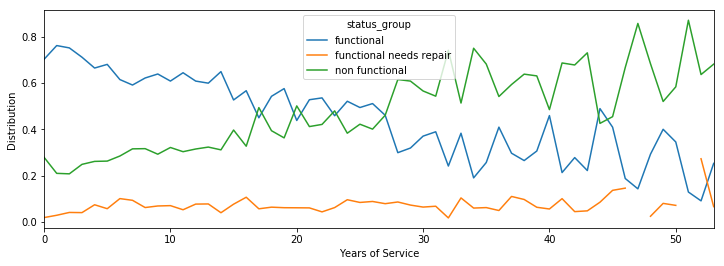

In [31]:
# Let's first study if waterpoint functionality is affected by years of service. 
# There is high chance that this will be true.
year_df = train_df[train_df['construction_year'] != 0].copy()
year_df['years_of_service'] = year_df['date_recorded'].apply(lambda x: x[:4]).astype(int) - year_df['construction_year'].astype(int)

# For contextual purposes, construction_year 0 is removed from analysis.
temp = year_df[year_df['construction_year'] != 0]
# Construction year should be prior to date_recorded, hence a negative value in years_of_service probably indicates
# bad value and hence is removed from analysis
temp['construction_year'].value_counts()
temp = temp[temp['years_of_service'] >= 0]
gb = temp.groupby(['years_of_service', 'status_group']).count()
temp2 = pd.DataFrame(temp.groupby(['years_of_service', 'status_group'])['status_group'].count())
temp3 = temp2.groupby(['years_of_service']).sum() 
temp2['perc'] = temp2['status_group']/temp3['status_group']
test = temp2.unstack()
ax = test['perc'].plot(kind='line', figsize=(12,4))
ax.set_ylabel('Distribution')
ax.set_xlabel('Years of Service')

# The trends somewhat coincide with our hypothesis that waterpoint functionality is related to its age or years of
# service. In this case, the distribution of non functional wells increases with increasing years of service. 
# This should be a good feature. Since the class 'functional needs repair' is imbalance in this data, its normal
# to not see an obvious trend there. Furthermore, we could foresee that the prediction performance in this class
# will be less impressive.

In [32]:
# Installer could be a potential indicator on a water point functionality. Proper installation definitely will pro-long
# the lifespan of the water pump. We will see below that certain installer does have pretty bad record.

code = 'installer'
train_df[code].value_counts()

a = train_df[code].value_counts().nlargest(10)
stat_df = pd.DataFrame(columns = ['count', 'functional', 'functional needs repair', 'non functional'])
def stat_summary(df, count, category):
    temp1 = df[df[code] == category]
    temp2 = temp1.groupby([code, 'status_group'])['status_group'].count()
    for i, val in temp2.iteritems():
        stat_df.loc[i[0], 'count'] = count
        stat_df.loc[i[0],i[1]] = 100.00*float(val)/float(len(temp1))

for i, val in a.iteritems():
    stat_summary(train_df, val, i)
stat_df

,count,functional,functional needs repair,non functional
DWE,17402,54.2064,9.32077,36.4728
Government,1825,29.3151,14.0274,56.6575
RWE,1206,25.2073,11.3599,63.4328
Commu,1060,68.3019,3.01887,28.6792
DANIDA,1050,51.619,7.90476,40.4762
KKKT,898,46.9933,6.90423,46.1024
Hesawa,840,56.5476,2.02381,41.4286
0,777,57.2716,0.3861,42.3423
TCRS,707,41.0184,5.94059,53.041
Central government,622,27.0096,0.643087,72.3473


# 2. Preprocessing the dataset
The first step is to go through the data briefly to get a field of overall data sanity. In most cases, a dataset usually has null values and it must be filled with some sensible values such as median or mean (if a column misses a lot of values, we should drop the column from investigation). In summary we need to work on preparing the data for analysis and modeling:

* fill in null values or drop column with high missing value rates 
* convert categorical data to numerical values
* ensure all column is properly scaled

In [38]:
# Reload the dataset
train_set = pd.read_csv('train_set_values.csv')
train_label = pd.read_csv('train_set_labels.csv')
train_df = train_set.merge(train_label, on = 'id') 


In [39]:
train_df[train_df['construction_year'] == 0].groupby(['construction_year', 'region'])['region'].count()
# There is approximately 20,000 rows of zero values in construction_year. These missing values are concentrated in
# a few regions - Dodoma, Kagera, Mbeya, Mwanza, Shinyanga, Tabora. construction_year can be used to approximate age
# of the wells and hence we must take caution when imputing this column


construction_year  region       
0                  Arusha             51
                   Dar es Salaam      17
                   Dodoma           2201
                   Iringa            372
                   Kagera           3316
                   Kigoma             10
                   Kilimanjaro        35
                   Lindi             113
                   Manyara            13
                   Mara               17
                   Mbeya            4639
                   Morogoro           18
                   Mtwara             87
                   Mwanza           2747
                   Pwani             176
                   Rukwa               2
                   Ruvuma             16
                   Shinyanga        4818
                   Singida             8
                   Tabora           1959
                   Tanga              94
Name: region, dtype: int64

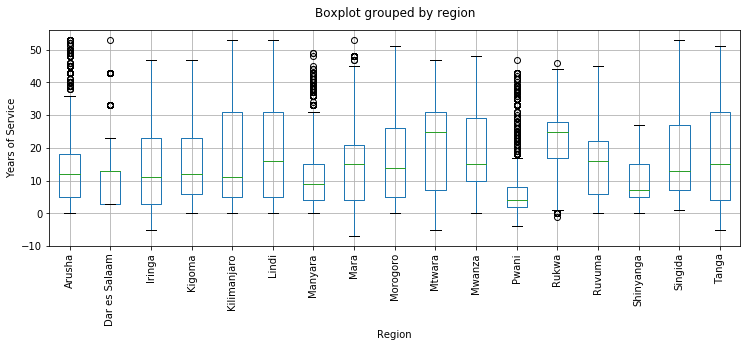

In [42]:
train_df['years_of_service'] = train_df['date_recorded'].apply(lambda x: x[:4]).astype(int) - train_df['construction_year'].astype(int)

# The years_of_service that are very high in value are due to zero value construction year. To minimize noise,
# we can fill these values based on the mean value by geographic region. This is under the assumption that water pump
# in the same region has similar age. Let's verify this by box plot
ax = train_df[train_df['years_of_service'] < 100].boxplot(column='years_of_service', by='region', figsize=(12,4), rot=90)
ax.set_ylabel('Years of Service')
ax.set_xlabel('Region')
ax.set_title('')

# Adding years_of_service as age of wells based on difference of date_recorded and construction_year
def years_of_service(train_df):
    train_df['years_of_service'] = train_df['date_recorded'].apply(lambda x: x[:4]).astype(int) - train_df['construction_year'].astype(int)
    train_df['years_of_service'].astype(int, inplace=True)
    gt_100 = train_df['years_of_service'] > 100
    neg = train_df['years_of_service'] < 0
    train_df.loc[gt_100, 'years_of_service'] = 0
    train_df.loc[neg, 'years_of_service'] = 0
    return train_df


train_df = years_of_service(train_df)

From the boxplot, there are four regions with many outliers. There are also construction_year that is prior to recorded date which give negative construction_year. The best bet is to fill the missing values with 0's for now and see how it performs. Another way is to probe further into this relationship or study the distribution with respect to other predictor. We can come back and revisit the features if necessary.

In [19]:
# Fill missing values.
train_df.apply(lambda x: sum(x.isnull()), axis=0)

def fill_missing(train_df):
    train_df['installer'].replace('0', train_df['installer'].mode()[0], inplace=True)
    train_df['district_code'].replace(0, train_df['district_code'].mode()[0], inplace=True)

    train_df['installer'].fillna(train_df['installer'].mode()[0], inplace=True)
    train_df['scheme_management'].fillna(train_df['scheme_management'].mode()[0], inplace=True)
    train_df['permit'].fillna(train_df['permit'].mode()[0], inplace=True)
    train_df['public_meeting'].fillna(train_df['public_meeting'].mode()[0], inplace=True)
    return train_df

train_df = fill_missing(train_df)
train_df[]

In [20]:
from sklearn.preprocessing import minmax_scale, LabelEncoder

# Feature Scaling and Categorization
col_to_scale = ['gps_height']
col_to_log_transform = ['amount_tsh', 'population', 'years_of_service']
col_to_category = ['basin', 'region_code', 'district_code', 'scheme_management', 'permit', 'public_meeting', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type', 'status_group'] 

for col in col_to_scale:
    train_df[col] = minmax_scale(train_df[col])

for col in col_to_log_transform:
    train_df[col] = train_df[col].apply(lambda x: np.log(x + 1))

encoder_dict = {}
for col in col_to_category:
    encoder = LabelEncoder()
    encoder.fit(train_df[col])
    encoder_dict[col] = encoder
    train_df[col] = encoder.transform(train_df[col])
    
    

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# Feature reduction. Based on our earlier reasonings, columns with similar context or without context are dropped.
# Examples of column without much context are date_recorded, recorded_by, num_private, etc.
col_to_drop = ['date_recorded', 'funder', 'installer', 'region', 'subvillage', 'lga', 'ward', 'scheme_name', 'construction_year', 'wpt_name', 'num_private','extraction_type', 'extraction_type_group','source', 'source_class','recorded_by','water_quality', 'payment', 'quantity', 'management', 'waterpoint_type_group']
train_df.drop(col_to_drop, axis=1, inplace=True)


# 3. Machine Learning Modeling

In this section, we will attempt our modeling using the Random Forest algorithm. This algorithm is known to be less
prone to overfitting due the ability to incorporate randomness into the building it. We will also follow cross 
validation approach when building the model. The grid search approach will be used to find the optimal parameters.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest is essentially an ensemble of decision trees. Diversity is ensured by using random subset of training
# data to train each decision tree. This greatly reduces overfitting problem which is common in many machine learning
# problem. Below are three more critical parameters of the algorithm.

# n_estimators - number of trees in the Random Forest Model
# max_depth - max number of levels in each tree
# random_state - seed value of random number generator

train_input = train_df.drop(['id','status_group'], axis =1).copy()
train_status = train_df['status_group'].copy()

X_train, X_cv, Y_train, Y_cv = train_test_split(train_input, train_status, test_size=0.20, random_state=10)

# GridSearchCV is a very convenient tool to assist us find the best set of parameters to build our model.
params_gs = [{'n_estimators': [110, 130, 140, 150], 'random_state': [20], 'max_depth': [12, 30, 35, 40, 45, 50]}]

# Since we have quite an imbalance class with 'functional needs repair' class at least 4 times smaller than
# 'non functional' and 6 times smaller than 'functional', we should configure the model to balance class weight.
rfc = RandomForestClassifier(random_state=0, class_weight='balanced')
clf = GridSearchCV(rfc, params_gs, cv=5)
clf.fit(X_train, Y_train)

params_tup = clf.cv_results_['params']
mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

for i in range(0, len(params_tup)):
    print('Training:\t', params_tup[i], ' - ', round(mean_train_score[i],3))
    print('Test:\t\t', params_tup[i], ' - ', round(mean_test_score[i],3))

print('\nBest parameters: ', clf.best_params_)
params = clf.best_params_
y_res = clf.predict(X_cv)
print(classification_report(Y_cv, y_res))

estimator = clf.best_estimator_

feats = pd.Series(estimator.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
print('Features ranked by their importances:\n')
print(feats)

# Although the model validation steps are quite specific to tree based models which we could further experiment 
# with XGBoost, the approach applies to all kinds of machine learning modeling.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Training:	 {'max_depth': 12, 'n_estimators': 110, 'random_state': 20}  -  0.772
Test:		 {'max_depth': 12, 'n_estimators': 110, 'random_state': 20}  -  0.726
Training:	 {'max_depth': 12, 'n_estimators': 130, 'random_state': 20}  -  0.772
Test:		 {'max_depth': 12, 'n_estimators': 130, 'random_state': 20}  -  0.726
Training:	 {'max_depth': 12, 'n_estimators': 140, 'random_state': 20}  -  0.772
Test:		 {'max_depth': 12, 'n_estimators': 140, 'random_state': 20}  -  0.725
Training:	 {'max_depth': 12, 'n_estimators': 150, 'random_state': 20}  -  0.772
Test:		 {'max_depth': 12, 'n_estimators': 150, 'random_state': 20}  -  0.726
Training:	 {'max_depth': 30, 'n_estimators': 110, 'random_state': 20}  -  0.993
Test:		 {'max_depth': 30, 'n_estimators': 110, 'random_state': 20}  -  0.799
Training:	 {'max_depth': 30, 'n_estimators': 130, 'random_state': 20}  -  0.993
Test:		 {'max_depth': 30, 'n_estimators': 130, 'random_state': 20}  -  0.799
Training:	 {'max_depth': 30, 'n_estimators': 140, 'random_

The top four features are pretty significant to the model. In general, the feature sets are quite balanced in
terms of significance except the top four (dominating) and the last one (negligible). These features also make sense
and align with our initial hypotheses. Another way to study feature importances is using AdaBoost.

Other features which could improve prediction performance can be derived from meaningful categorization of funder,
installer, and complete data in construction_year since years_of_service is quite strong as a feature too, as was
shown in the trend chart earlier. Given more time, these are the things that can be explored.

In [33]:
# Model Validation. To understand how well the model will perform against future data, we could use the 
# cross validation approach. Namely, we randomly pick a sample out of the training data say 80% to train the model.
# The remaining 20% training data is used for validation which allows us to evaluate the model tendency to overfit.

from sklearn.model_selection import cross_val_score
import statistics as stat
estimator = clf.best_estimator_
cross_val = cross_val_score(estimator, X_train, Y_train, cv=10)

print(cross_val)
print(stat.mean(cross_val))

[0.80012624 0.80475489 0.80622765 0.79928466 0.79507679 0.79419192
 0.80281987 0.79688487 0.79915789 0.81031579]
0.8008840564395083


In [43]:
# Read test data into dataframe and apply the same set of preprocessing
test_df = pd.read_csv('test_set_values.csv')

test_df = years_of_service(test_df)
test_df = fill_missing(test_df)

for col in col_to_scale:
    test_df[col] = minmax_scale(test_df[col])

for col in col_to_log_transform:
    test_df[col] = test_df[col].apply(lambda x: np.log(x + 1))
    
for col in col_to_category:
    if col != 'status_group':
        encoder = encoder_dict[col]
        test_df[col] = encoder.transform(test_df[col])

test_df.drop(col_to_drop, axis=1, inplace=True)
    

    

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [44]:
# Run the model against test dataset and output the submission csv file.
res_key = ['id', 'status_group']
encoder = encoder_dict[res_key[1]]

test_result = clf.predict(test_df.drop('id', axis=1))
test_res_df = pd.DataFrame(columns=res_key)
test_res_df[res_key[0]] = test_df[res_key[0]]
test_res_df[res_key[1]] = encoder.inverse_transform(test_result)

test_res_df.to_csv('submission.csv', index=False)